In [1]:
from itertools import product as prod
import numpy as np
import sympy as sym
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from sympy import solveset, S

In [2]:
def howmany(x):
    x = int(x)
    n = int(-1.5+(0.5)*np.sqrt(8*x+1))
    M = (0.5)*(n+1)*(n+2)
    if M >= x:
        return n
    else:
        return n+1

def chi_list(N, sym1, sym2):
    N_fixed = N
    N = howmany(N)+1
    tuples = []

    deg = range(N)
    indices = prod(deg,deg)
    
    A = np.zeros((N,N,2))
    for (i,j) in indices: 
        A[i,j] = (i,j)
    
    # For each column start row is 0
    for col in range(N):

        startcol = col
        startrow = 0

        while(startcol >= 0 and
              startrow < N):
            tuples.append(tuple(A[startcol][startrow]))

            startcol -= 1
            startrow += 1

    tuples.pop(0)

    chi = []
    for item in tuples:
        degz = int(item[0])
        degw = int(item[1])
        chi.append(sym.poly(sym1**degz*sym2**degw))
    chi.insert(0, 1)
    
    return chi[0:N_fixed]

def innerprod(dict1, dict2):
    ip = []
    for key in dict1:
        if key in dict2:
            ip.append(complex(dict1[key]*np.conj(dict2[key])))
    ip = np.sum(np.array(ip))
    return ip

def chi_mult_list(f,degree, sym1, sym2):
    chi = chi_list(degree, sym1, sym2)
    mults = []
    for mono in chi:
        mults.append(sym.poly(f*mono, sym1,sym2))
    return mults

def convert_if_real(G):
    N = G.shape[0]
    n = range(N)
    indices = prod(n,n)
    boolist=[]
    for (i,j) in indices:
        boolist.append(G[i,j].imag==0)
    if all(boolist):
        indices = prod(n,n)
        H = np.zeros((N,N))
        for (i,j) in indices:
            H[i,j] = G[i,j].real
        return H
    else:
        return G

def Grammian(f, degree, sym1, sym2):
    chi_mults = chi_mult_list(f,degree, sym1, sym2)
    N = len(chi_mults)
    n = range(N)
    indices = prod(n,n)
    G = np.zeros((N,N), dtype = 'complex_')
    for (i,j) in indices:
        poly1 = chi_mults[i].as_dict()
        poly2 = chi_mults[j].as_dict()
        G[i,j] = innerprod(poly1,poly2)
    G = convert_if_real(G)
    return G

def vect(f, degree ,sym1, sym2):
    F = sym.lambdify((sym1,sym2),f, "mpmath")
    vect = [F(0,0)]
    N = len(chi_list(degree, sym1, sym2))
    for i in range(N-1):
        vect.append(0)
    vect = np.array(vect)
    return vect

def OPA(f, degree, sym1, sym2):
    G = Grammian(f, degree, sym1, sym2)
    b = vect(f, degree, sym1, sym2)
    x = np.linalg.inv(G)@b
    basis = chi_list(degree, sym1, sym2)
    opa = np.dot(x, basis)
    # need a small exception for first opa
    if type(opa) == np.float64:
        return opa
    else:
        opa = opa.as_expr()
        return opa


**Computing an OPA of a poly f of any degree**

In [3]:
w,z = sym.symbols('w,z')
z.is_complex
w.is_complex

In [4]:
f = w**2+z**2+1

In [5]:
for i in range(20):
    print('p*_'+str(i+1)+' = ',OPA(f, i+1, z, w))

    

p*_1 =  0.3333333333333333
p*_2 =  0.333333333333333
p*_3 =  0.333333333333333
p*_4 =  0.375 - 0.125*z**2
p*_5 =  0.375 - 0.125*z**2
p*_6 =  -0.1*w**2 - 0.1*z**2 + 0.4
p*_7 =  -0.1*w**2 - 0.1*z**2 + 0.4
p*_8 =  -0.1*w**2 - 0.1*z**2 + 0.4
p*_9 =  -0.1*w**2 - 0.1*z**2 + 0.4
p*_10 =  -0.1*w**2 - 0.1*z**2 + 0.4
p*_11 =  -0.0961538461538462*w**2 + 0.0384615384615385*z**4 - 0.115384615384615*z**2 + 0.403846153846154
p*_12 =  -0.0961538461538462*w**2 + 0.0384615384615385*z**4 - 0.115384615384615*z**2 + 0.403846153846154
p*_13 =  0.0782608695652174*w**2*z**2 - 0.121739130434783*w**2 + 0.0173913043478261*z**4 - 0.130434782608696*z**2 + 0.417391304347826
p*_14 =  0.0782608695652174*w**2*z**2 - 0.121739130434783*w**2 + 0.0173913043478261*z**4 - 0.130434782608696*z**2 + 0.417391304347826
p*_15 =  0.0181818181818182*w**4 + 0.0727272727272727*w**2*z**2 - 0.127272727272727*w**2 + 0.0181818181818182*z**4 - 0.127272727272727*z**2 + 0.418181818181818
p*_16 =  0.0181818181818182*w**4 + 0.0727272727272727

In [24]:
def v_func(variety, variable ,value):
    v = sym.lambdify(variable,variety, "mpmath")
    return float(v(value).real)+1j*float(v(value).imag)

def variety_plot(variety, variable):
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Make data.
    r=2 #make a 2r x 2r square around 0. 
    X = np.arange(-r, r, 0.1)
    Y = np.arange(-r, r, 0.1)
    X, Y = np.meshgrid(X, Y)
    N = X.shape
    Z_real = np.zeros(N)
    Z_imag = np.zeros(N)
    Mod = np.zeros(N)
    indices = prod(range(N[0]), range(N[1]))
    for (i,j) in indices:
        value = v_func(variety, variable ,X[i,j]+1j*Y[i,j])
        Z_real[i,j] = value.real
        Z_imag[i,j] = value.imag
        if np.abs(value)<1:
            Mod[i,j] = np.abs(value)
        else: 
            Mod[i,j] = float('nan')
    

    #color mapping
    norm=mpl.colors.Normalize(-np.pi,np.pi)
    my_col = cm.hsv(norm(np.arctan2(Z_imag,Z_real))) #hsv is a cyclic color map
    floor_col = cm.hsv(norm(np.arctan2(Y,X)))


    surf = ax.plot_surface(X, Y, Mod, alpha = 0.25,  facecolors = my_col, linewidth=0, antialiased=False) #surface color
    bottom = ax.plot_surface(X, Y, 0*X, alpha = 0.25 , facecolors = floor_col, linewidth=0, antialiased=False) #floor color for ref
    x = np.cos(np.arange(0, 2*np.pi, 0.01))
    y = np.sin(np.arange(0, 2*np.pi, 0.01))
    plt.plot(x,y, color = 'black')
    #ax.scatter((1/np.sqrt(2))*np.cos(np.pi/2), (1/np.sqrt(2))*np.sin(np.pi/2), (1/np.sqrt(2)))

    # Customize the z axis.
    maxvalue=1
    ax.set_zlim(0, maxvalue)


    plt.show()

In [25]:
varieties = solveset(f, w)

In [26]:
varieties = list(varieties)

In [27]:
v = varieties[0]

<IPython.core.display.Javascript object>


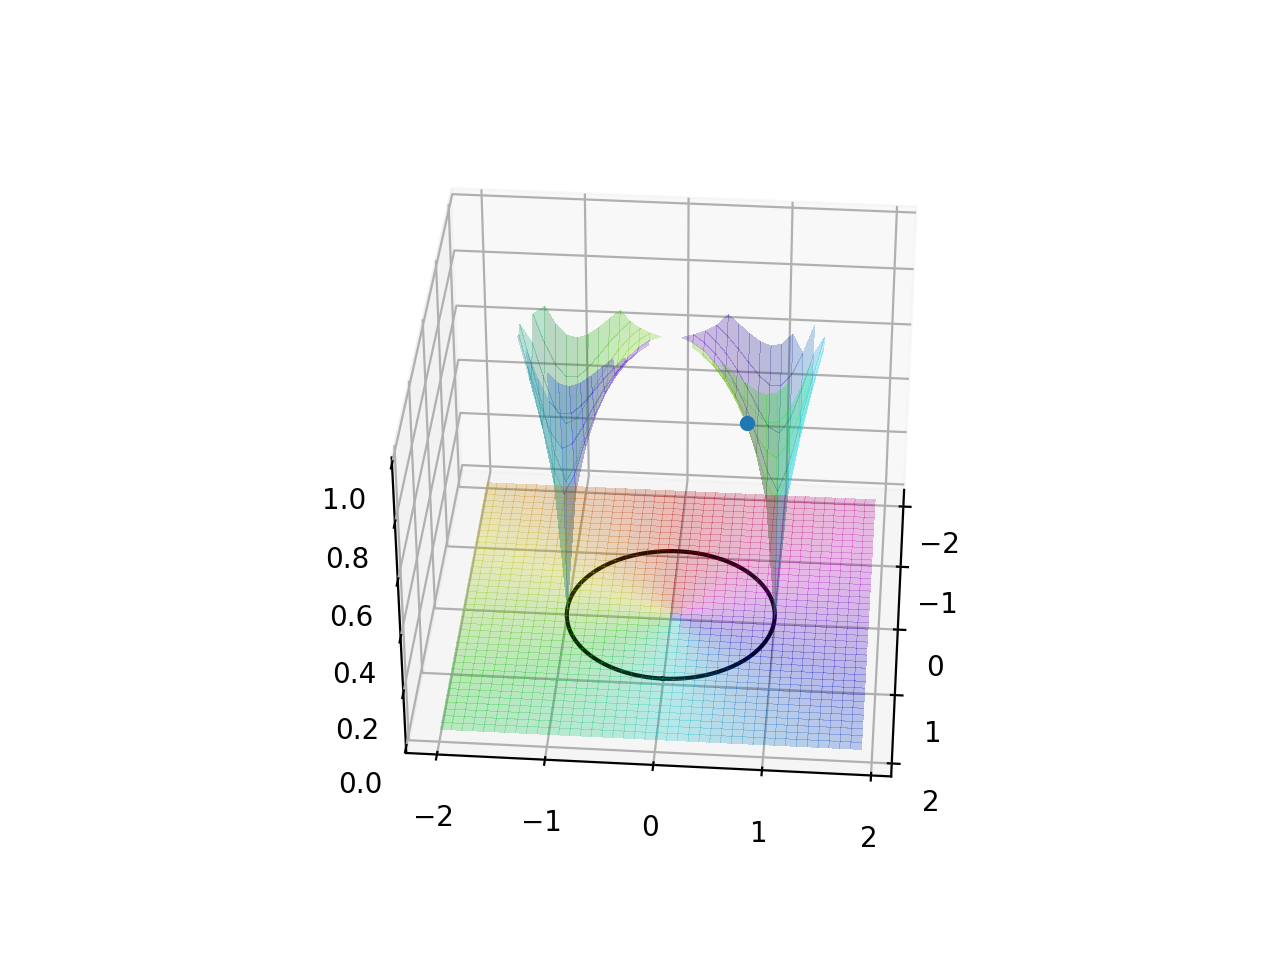

/var/folders/z2/zhpn1lzs3xjbxj9xc8ts773jwby2tm/T/ipykernel_15507/2974229219.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')
/var/folders/z2/zhpn1lzs3xjbxj9xc8ts773jwby2tm/T/ipykernel_15507/2974229219.py:35: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(X, Y, Mod, alpha = 0.25,  facecolors = my_col, linewidth=0, antialiased=False) #surface color


In [28]:
%matplotlib notebook
variety_plot(v, z)